In [186]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from autils import *
import matplotlib.pyplot as plt
from utils import *
import copy
import math
import plotly.express as px
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import graphviz
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [187]:
# Load dataset
data = pd.read_excel("credit_risk_dataset_edited_xlsx.xlsx")

The below cell removes outliers in the dataset. For some reason, there were some anomalies in the original dataset where some ages and employment length were well above 100. This removes those examples. The code below that removes any examples where the data is null.

In [188]:
data = data[data["person_age"]<=100]
data = data[data["person_emp_length"]<=100]
data = data[data["person_income_thousands"]<= 4000]

data.dropna(subset=['loan_int_rate'], inplace=True)
data.dropna(subset=['loan_grade'], inplace=True)
data.dropna(subset=['person_emp_length'], inplace=True)

X = data.drop("loan_status", axis=1) # all columns except the target variable
y = data["loan_status"]

In [189]:
data.describe()

person_age  person_income_thousands  loan_intent_personal  \
count  28573.000000             28573.000000          28573.000000   
mean      27.710881                66.400553              0.170266   
std        6.173805                51.558668              0.375873   
min       20.000000                 4.000000              0.000000   
25%       23.000000                39.396000              0.000000   
50%       26.000000                55.784000              0.000000   
75%       30.000000                80.000000              0.000000   
max       84.000000              2039.784000              1.000000   

       loan_intent_education  loan_intent_medical  loan_intent_venture  \
count           28573.000000         28573.000000         28573.000000   
mean                0.199244             0.184860             0.174535   
std                 0.399439             0.388191             0.379576   
min                 0.000000             0.000000             0.000000   
25%                 0.000000             0.000000             0.000000   
50%                 0.000000             0.000000             0.000000   
75%                 0.000000             0.000000             0.000000   
max                 1.000000             1.000000             1.000000   

       loan_intent_homeimprovement  loan_intent_debtconsolidation  \
count                 28573.000000                   28573.000000   
mean                      0.111609                       0.159486   
std                       0.314890                       0.366135   
min                       0.000000                       0.000000   
25%                       0.000000                       0.000000   
50%                       0.000000                       0.000000   
75%                       0.000000                       0.000000   
max                       1.000000                       1.000000   

       person_emp_length    loan_grade  loan_amnt_thousands  loan_int_rate  \
count       28573.000000  28573.000000         28573.000000   28573.000000   
mean            4.778112      5.623036             9.637808      11.020680   
std             4.034801      1.469565             6.313231       3.205109   
min             0.000000      0.000000             0.500000       5.420000   
25%             2.000000      5.000000             5.000000       7.900000   
50%             4.000000      6.000000             8.000000      10.990000   
75%             7.000000      7.000000            12.400000      13.470000   
max            41.000000      7.000000            35.000000      22.060000   

       cb_person_default_on_file  cb_person_cred_hist_length   loan_status  
count               28573.000000                28573.000000  28573.000000  
mean                    0.177370                    5.792356      0.215028  
std                     0.381988                    4.038312      0.410849  
min                     0.000000                    2.000000      0.000000  
25%                     0.000000                    3.000000      0.000000  
50%                     0.000000                    4.000000      0.000000  
75%                     0.000000                    8.000000      0.000000  
max                     1.000000                   30.000000      1.000000

Below we take a look at the data to try and identify some of the patterns. In the scatterplot, examples that have a positive default on their loan are red and examples that have a negative default on their loan are blue.

In [190]:
figure = px.scatter_matrix(data, dimensions=
["person_age","person_income_thousands","loan_intent_personal","loan_intent_education","loan_intent_medical","loan_intent_venture","loan_intent_homeimprovement","loan_intent_debtconsolidation", "person_emp_length","loan_grade","loan_amnt_thousands", "loan_int_rate", "cb_person_default_on_file", "cb_person_cred_hist_length" ],
labels={col:col.replace('_', ' ') for col in data.columns}, height=3000, width=3000, color="loan_status", color_continuous_scale=px.colors.sequential.Bluered)

figure.show()

In [191]:
data_nonDefault = data[data.loan_status == 0].loan_status.count() / data.loan_status.count()
print("Percentage of non-default cases: " + str(data_nonDefault))
data_default = data[data.loan_status == 1].loan_status.count() / data.loan_status.count()
print("Percentage of default cases: " + str(data_default))

Percentage of non-default cases: 0.7849718265495398
Percentage of default cases: 0.2150281734504602


It is important to see that our dataset is unbalanced as shown in the cell above. This may cause some problems with the neural network later because it raises challenges to feature correlation, class separation and evaluation, and may eventually lead to poor model performance.

Note: I tried to use the smote function from the IMBlearn library to try to deal with the unbalanced data. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short. Howeever, this actually worsened model performance by a little bit. After researching online, I found that SMOTE is used mostly for highly unbalanced datasets and will not change much at all when the dataset is slightly unbalanced.

In [192]:
# Break the dataset up into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=2)

I experimented with different actication functions but did not find a huge difference between some of them. Relu seemed to be the best by a little bit in the hidden layers. Sigmoid was used in the output layer for more simple classification. Five layers also seemed to be the best when it came to model performace.

In [193]:
model = Sequential([
    tf.keras.Input(shape=(14,)),
    Dense(units=256, activation="LeakyReLU"),
    Dense(units=128, activation="LeakyReLU"),
    Dense(units=64, activation="LeakyReLU"),
    Dense(units=32, activation="LeakyReLU"),
    Dense(units=16, activation="LeakyReLU"),
    Dense(units=1, activation="sigmoid"),
], name="my_model")

ValueError: Unknown activation function 'Leakyrelu' cannot be deserialized.

In [ ]:
def lr_schedule(epoch):
    return 1e-3 * (0.1 ** (epoch // 10))

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=40, callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/40
777/777 [==============================] - 3s 2ms/step - loss: 0.3888 - accuracy: 0.8367 - lr: 0.0010
Epoch 2/40
777/777 [==============================] - 2s 2ms/step - loss: 0.3509 - accuracy: 0.8561 - lr: 0.0010
Epoch 3/40
777/777 [==============================] - 2s 2ms/step - loss: 0.3425 - accuracy: 0.8602 - lr: 0.0010
Epoch 4/40
777/777 [==============================] - 2s 3ms/step - loss: 0.3374 - accuracy: 0.8643 - lr: 0.0010
Epoch 5/40
777/777 [==============================] - 2s 2ms/step - loss: 0.3315 - accuracy: 0.8676 - lr: 0.0010
Epoch 6/40
777/777 [==============================] - 2s 2ms/step - loss: 0.3248 - accuracy: 0.8726 - lr: 0.0010
Epoch 7/40
777/777 [==============================] - 2s 2ms/step - loss: 0.3194 - accuracy: 0.8761 - lr: 0.0010
Epoch 8/40
777/777 [==============================] - 2s 3ms/step - loss: 0.3159 - accuracy: 0.8794 - lr: 0.0010
Epoch 9/40
777/777 [==============================] - 2s 3ms/step - loss: 0.3120 - accuracy: 0.8

After we have complied our model, we can take a look at its performace in the following code:

In [ ]:
def model_assess(input_model, name='default' ):

    input_model.fit(X_train, y_train)

    y_pred_binary = [1 if val > 0.5 else 0 for val in input_model.predict(X_test)]

    print('                   ', name, '\n',
          classification_report(y_test, y_pred_binary))

model_assess(model, "Neural Network" )


117/117 [==============================] - 0s 1ms/step
                    Neural Network 
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      2908
           1       0.78      0.70      0.74       807

    accuracy                           0.89      3715
   macro avg       0.85      0.82      0.84      3715
weighted avg       0.89      0.89      0.89      3715



117/117 [==============================] - 0s 1ms/step


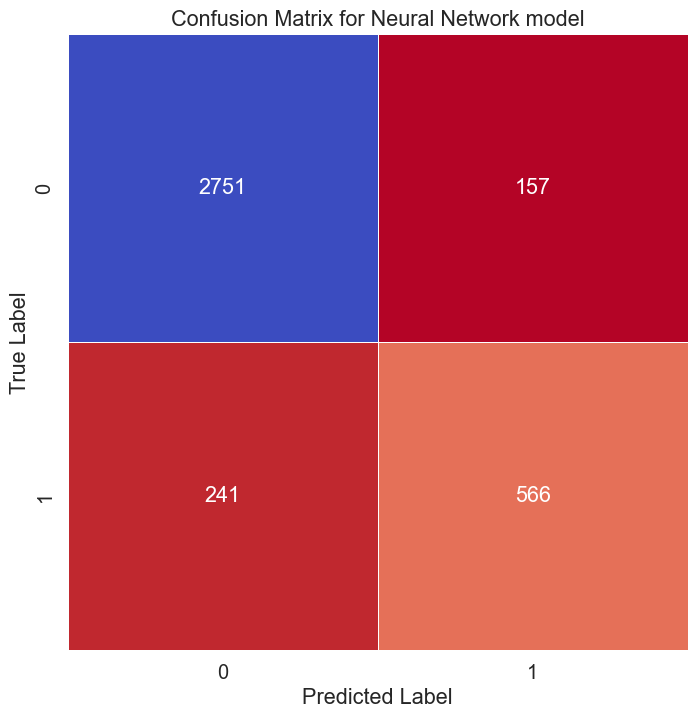

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns


y_pred_binary = [1 if val > 0.5 else 0 for val in model.predict(X_test)]
xr_matrix = confusion_matrix(y_test, y_pred_binary)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(xr_matrix,annot=True, cbar=False, cmap='coolwarm_r',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Neural Network model');

We can see from the above tables that the model is good at predicting a true 0. However, we do see some inefficienies as the model has a tendency to predict a 0 when it is a true 1. This is reflected in the low recall score for class 1. This could lead to some problems in the context of the project because the model is predicting that the lender will not default, even though they do. As mentioned previously, this is most likely due to the unbalanced dataset and may need further action to improve.

Now, taking a look at our second ML method for this project, decision trees.

In [ ]:
from sklearn import tree
from sklearn.datasets import load_iris

In [ ]:
treeData = tree.DecisionTreeClassifier()
treeData = treeData.fit(X_train, y_train)

Similar to what we did for the neural network, we can take a look at the decision tree performace in the following code:

In [ ]:
y_pred = treeData.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2908
           1       0.62      0.67      0.64       807

    accuracy                           0.84      3715
   macro avg       0.76      0.78      0.77      3715
weighted avg       0.84      0.84      0.84      3715



Based on this, we can see that the decsision tree performed very similar to the neural network when it comes to model accuracy. When we use XGBoost, we actually see a model performance that is slightly better than the neural network. This demonstrates how XGBoost can help deal with the unbalanced dataset. By sequentially adding weak learners to the model and adjusting their weights based on the errors made in the previous iterations, XGBoost can effectively capture the patterns in the data, including the minority class. Let's also take a look at the confusion matrix to see if there are any changes:

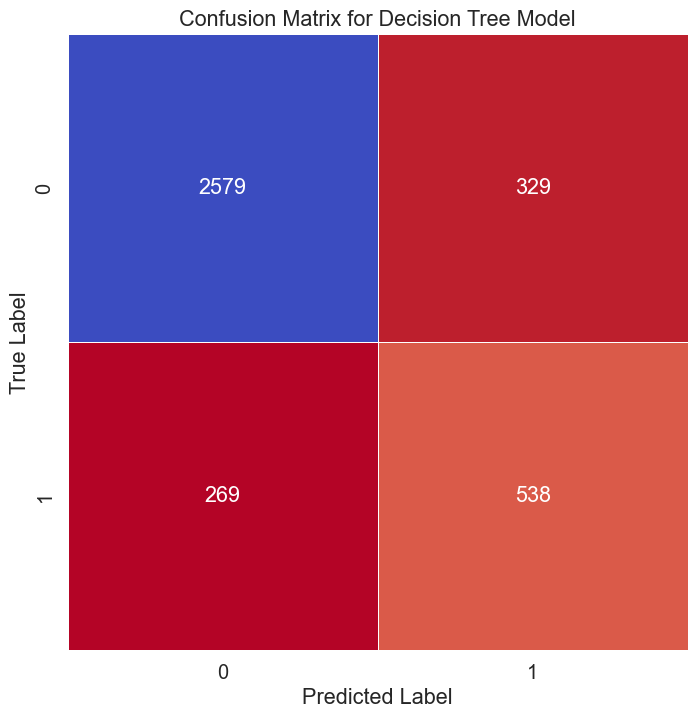

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns


y_pred=treeData.predict(X_test)
tr_matrix = confusion_matrix(y_test,y_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(tr_matrix,annot=True, cbar=False, cmap='coolwarm_r',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision Tree Model');

As shown, the decission tree performance was overall very comparable to the neural network when it came to the confusion matrix. Let's take a look at another form of a decsion tree and see if we can improve our classification:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forestData = RandomForestClassifier(max_depth=20, random_state=5)
forestData.fit(X_train, y_train)
forest_pred = forestData.predict(X_test)
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2908
           1       0.82      0.64      0.72       807

    accuracy                           0.89      3715
   macro avg       0.86      0.80      0.83      3715
weighted avg       0.89      0.89      0.89      3715



The max_depth of 20 was determined by trial and error. It seemed to be show the best results. Anything more than 20, and the classifier ran into overfitting problems, and anything under, the model ran into underfitting problems. 

Overall, like the other methods, we seem to still have a low recall for class 1 due to the unbalanced dataset.

Like we have done for the previous methods, we also should check the confusion matrix to see if anything changed.

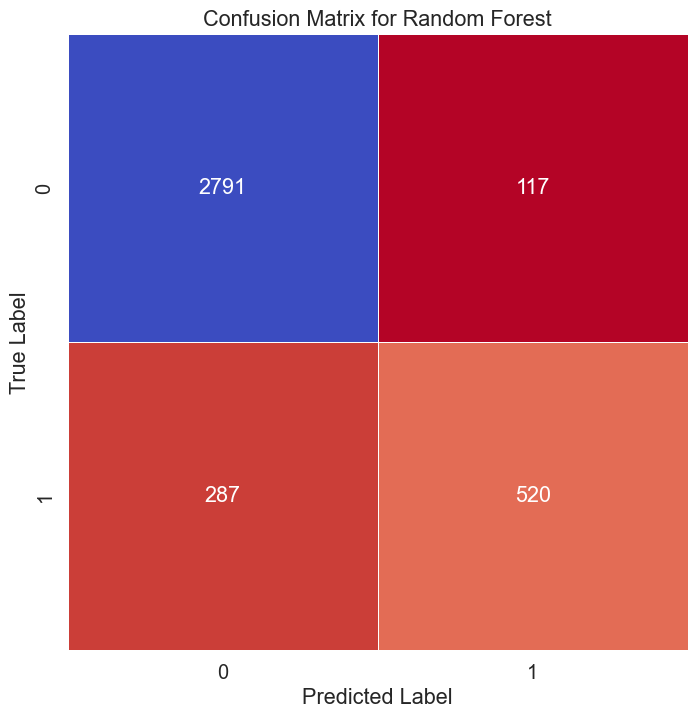

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns


forest_pred = forestData.predict(X_test)
tr_matrix = confusion_matrix(y_test,forest_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8, 8))
sns.heatmap(tr_matrix,annot=True, cbar=False, cmap='coolwarm_r',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Random Forest');


We actually saw a slight decrease in the misclassification of class 1. The is signified by the lower value in the bottom left box when compared to the other two methods so far.

Now, let's look at the AUC score of the decision tree. AUC represents the probability that a random positive example is positioned to the right of a random negative example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [ ]:
# Predict propabilities for the test data
tr_probs = treeData.predict_proba(X_test)

# Keep probabilities of the positive class only
tr_probs = tr_probs[:, 1]

# Compute the AUC Score for decision tree
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)



# Now for the random forest
# Predict propabilities for the test data
tr_probs = forestData.predict_proba(X_test)

# Keep probabilities of the positive class only
tr_probs = tr_probs[:, 1]

# Compute the AUC Score
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.78
AUC: 0.91


This means our decision tree is average and our random forest is above average. It is widely accepted that a model with an AUC score of less than 0.7 is bad, and anything more is either adequate or better.

Conclusion

Overall, I had a lot of fun working on this project. While the unbalanced dataset did lead to relatively poor model performance, I am happy with some of the outcomes I achieved. I really enjoyed taking this course and learning about all of the different data science techniques. I hope to continue my machine learning journey in the future.